<h2 style="color: #40a3ff;">Moondream3 Preview Model</h2>
<p><img src="https://moondream.ai/_next/image?url=%2Fimages%2Fblog%2Fmoondream-3-preview%2Ftitle-image.jpg&w=1920&q=75" alt="Moondream3" style="height:400px"> <img src="md_logo.svg" alt="Moondream3-Logo" style="height:400px"></p>

In [ ]:
!pip install PyAutoGUI

In [1]:
import torch
import time
from PIL import Image, ImageDraw
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
from transformers import AutoModelForCausalLM, AutoTokenizer

### Load Model

In [2]:
moondream = AutoModelForCausalLM.from_pretrained(
    "moondream/moondream3-preview",
    trust_remote_code=True,
    dtype=torch.bfloat16,
    device_map={"": "cuda"},
)
moondream.compile()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
print(moondream)

HfMoondream(
  (model): MoondreamModel(
    (vision): ModuleDict(
      (patch_emb): Linear(in_features=588, out_features=1152, bias=True)
      (blocks): ModuleList(
        (0-26): 27 x ModuleDict(
          (ln1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
          (attn): ModuleDict(
            (qkv): Linear(in_features=1152, out_features=3456, bias=True)
            (proj): Linear(in_features=1152, out_features=1152, bias=True)
          )
          (ln2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
          (mlp): ModuleDict(
            (fc1): Linear(in_features=1152, out_features=4304, bias=True)
            (fc2): Linear(in_features=4304, out_features=1152, bias=True)
          )
        )
      )
      (post_ln): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
      (proj_mlp): ModuleDict(
        (fc1): Linear(in_features=2304, out_features=8192, bias=True)
        (fc2): Linear(in_features=8192, out_features=2048, bias=True)
      )
    )
  

### Check Model Size

In [4]:
num_params = sum(p.numel() for p in moondream.parameters())
print("Parameters:", num_params)

dtype = next(moondream.parameters()).dtype
bytes_per_param = {torch.float32: 4, torch.float16: 2, torch.bfloat16: 2}.get(dtype, 4)
size_gb = num_params * bytes_per_param / (1024**3)
print(f"Approx size in memory: {size_gb:.2f} GB")

Parameters: 9268622832
Approx size in memory: 17.26 GB


### Load Images

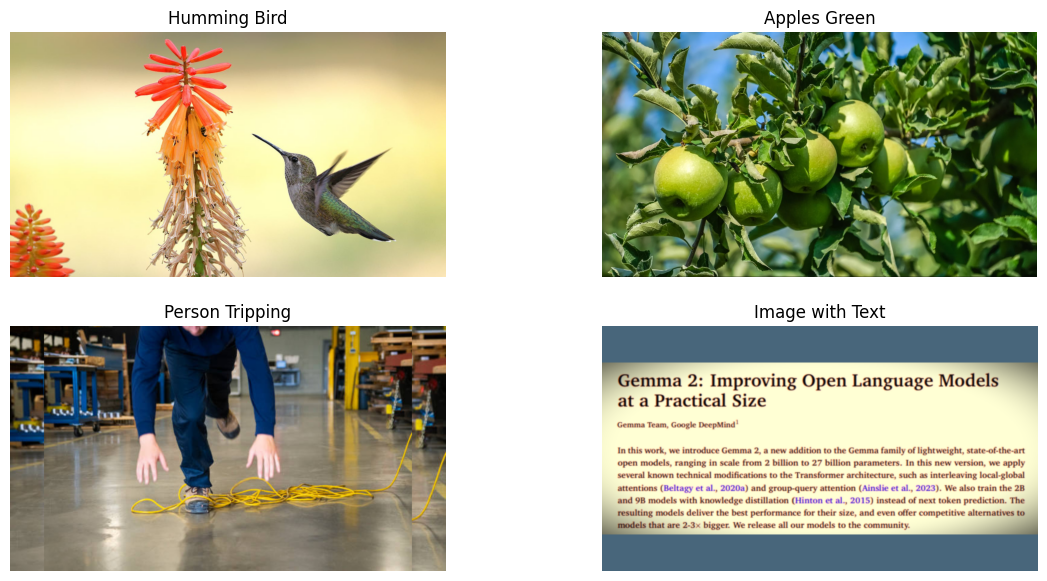

In [32]:
bird_img = Image.open("../../tasks/bird.jpg")
apple_img = Image.open("../../tasks/apples.png")
trip_img = Image.open("../../tasks/cable-trip.jpg")
ocr_img = Image.open("../../tasks/ocr.png")

# Display the image
plt.figure(figsize=(14,7))
plt.subplot(221); plt.imshow(bird_img); plt.title("Humming Bird"); plt.axis('off');
plt.subplot(222); plt.imshow(apple_img); plt.title("Apples Green"); plt.axis('off');
plt.subplot(223); plt.imshow(trip_img); plt.title("Person Tripping"); plt.axis('off');
plt.subplot(224); plt.imshow(ocr_img); plt.title("Image with Text"); plt.axis('off');

### Short Caption

In [6]:
# Long caption
torch.cuda.reset_peak_memory_stats()
t1 = time.time()
short = moondream.caption(bird_img, length="short")
t2 = time.time()

peak = torch.cuda.max_memory_allocated() / (1024**3)
print(f"Peak memory: {peak:.2f} GB")
print(f"Time taken : {round(t2-t1,2)} s")
print(f"\nShort: {short['caption']}")

Peak memory: 18.33 GB
Time taken : 14.58 s

Short: A hummingbird hovers near a tall flower with orange and red petals, its green body contrasting against the blurred background.


### Medium Caption

In [10]:
# Long caption
torch.cuda.reset_peak_memory_stats()
t1 = time.time()
normal = moondream.caption(bird_img, length="normal")
t2 = time.time()

peak = torch.cuda.max_memory_allocated() / (1024**3)
print(f"Peak memory: {peak:.2f} GB")
print(f"Time taken : {round(t2-t1,2)} s")
print(f"\nNormal: {normal['caption']}")

Peak memory: 18.27 GB
Time taken : 27.95 s

Normal: A hummingbird is captured in mid-flight near a vibrant orange and white flower. The bird's wings are outstretched, and its beak is pointed downward. The flower features a prominent central spike with smaller spikes extending outward, creating a striking contrast in color and texture. The background is a soft, blurred blend of yellow and green hues, providing a natural and serene setting for the scene.


### Long Caption

In [8]:
# Long caption
torch.cuda.reset_peak_memory_stats()
t1 = time.time()
long = moondream.caption(bird_img, length="long")
t2 = time.time()

peak = torch.cuda.max_memory_allocated() / (1024**3)
print(f"Peak memory: {peak:.2f} GB")
print(f"Time taken : {round(t2-t1,2)} s")
print(f"\nLong: {long['caption']}")

Peak memory: 18.33 GB
Time taken : 73.54

Long: The image presents a close-up view of a hummingbird in mid-flight, hovering near a vibrant flower. The hummingbird is positioned slightly to the right of the center of the frame, with its wings fully extended and its body angled downward. Its long, slender beak is pointed downward, and its body is covered in gray feathers with hints of green on its wings. The hummingbird's tail is black, and its wings are spread out, indicating its active state.

The flower is a striking feature of the image, located on the left side of the frame. It is tall and slender, with a reddish-orange color at the top transitioning to a pale yellow-orange at the bottom. The flower's structure is intricate, with numerous thin filaments extending outward. At the base of the flower, there is a small green stem. The flower's color gradient adds a dynamic element to the composition.

The background of the image is a soft, blurred yellow-green gradient, which helps to e

### Point to Objects

Peak memory: 18.27 GB
Time taken : 11.02 s
Point 1: x=368, y=566
Point 2: x=573, y=603
Point 3: x=798, y=450
Point 4: x=768, y=667
Point 5: x=924, y=366
Point 6: x=1044, y=487
Point 7: x=1188, y=493
Point 8: x=1503, y=450


(-0.5, 1596.5, 899.5, -0.5)

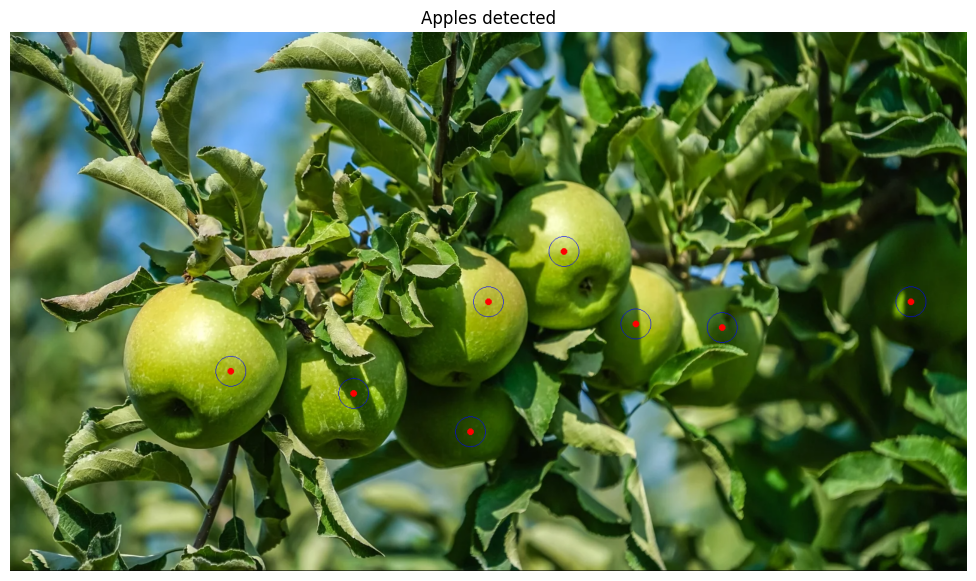

In [17]:
# Find points for specific objects
torch.cuda.reset_peak_memory_stats()
t1 = time.time()
result = moondream.point(apple_img, "Apples in the image")
t2 = time.time()

peak = torch.cuda.max_memory_allocated() / (1024**3)
print(f"Peak memory: {peak:.2f} GB")
print(f"Time taken : {round(t2-t1,2)} s")

width = apple_img.width
height = apple_img.height

annotated_img = apple_img.copy()
draw = ImageDraw.Draw(annotated_img)

rad = 5

# Points are normalized coordinates (0-1)
for i, point in enumerate(result["points"]):
    abs_x = int(point['x'] * width)
    abs_y = int(point['y'] * height)
    print(f"Point {i+1}: x={abs_x}, y={abs_y}")
    draw.ellipse((abs_x - rad, abs_y - rad, abs_x + rad, abs_y + rad), outline="red", fill="red")
    draw.ellipse((abs_x - rad*5, abs_y - rad*5, abs_x + rad*5, abs_y + rad*5), outline="blue")
    
    
plt.figure(figsize=(14,7))
plt.imshow(annotated_img); plt.title("Apples detected");
plt.axis("off")

Peak memory: 18.27 GB
Time taken : 13.8 s


(-0.5, 1596.5, 899.5, -0.5)

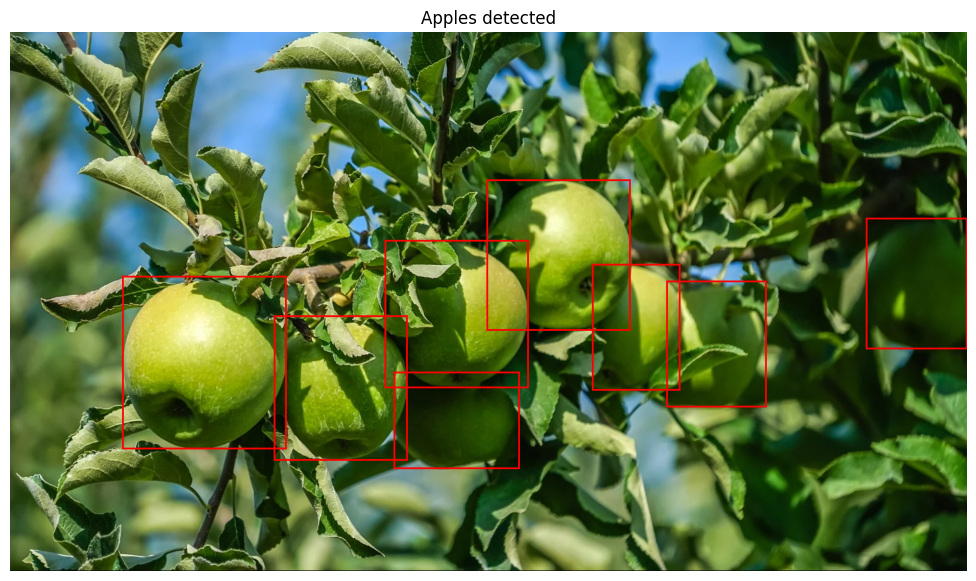

In [22]:
# Detect objects with bounding boxes
torch.cuda.reset_peak_memory_stats()
t1 = time.time()
result = moondream.detect(apple_img, "apple")
t2 = time.time()

annotated_bbox = apple_img.copy()
draw = ImageDraw.Draw(annotated_bbox)

peak = torch.cuda.max_memory_allocated() / (1024**3)
print(f"Peak memory: {peak:.2f} GB")
print(f"Time taken : {round(t2-t1,2)} s")

# Bounding boxes are normalized coordinates (0-1)
for i, obj in enumerate(result["objects"]):
    x_min=int(obj['x_min']*width)
    y_min=int(obj['y_min']*height)
    x_max=int(obj['x_max']*width)
    y_max=int(obj['y_max']*height)
    draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)

# # Control maximum number of objects
# settings = {"max_objects": 10}
# result = moondream.detect(image, "person", settings=settings)

plt.figure(figsize=(14,7))
plt.imshow(annotated_bbox); plt.title("Apples detected");
plt.axis("off")

### VQA on Images Without Reasoning

In [33]:
torch.cuda.reset_peak_memory_stats()
t1 = time.time()
# Without reasoning for simple questions
result = moondream.query(
    image=trip_img, 
    question="What is the color of the cable in the image?",
    reasoning=False
)
t2 = time.time()
peak = torch.cuda.max_memory_allocated() / (1024**3)
print(f"Peak memory: {peak:.2f} GB")
print(f"Time taken : {round(t2-t1,2)} s")

print(result["answer"])

Peak memory: 18.27 GB
Time taken : 9.22 s
The color of the cable in the image is yellow.


### VQA on Images With Reasoning

In [34]:
torch.cuda.reset_peak_memory_stats()
t1 = time.time()
# Without reasoning for simple questions
result = moondream.query(
    image=trip_img, 
    question="Why is the person falling?",
    # reasoning=False
)
t2 = time.time()
peak = torch.cuda.max_memory_allocated() / (1024**3)
print(f"Peak memory: {peak:.2f} GB")
print(f"Time taken : {round(t2-t1,2)} s")

print(result["answer"])

Peak memory: 18.27 GB
Time taken : 15.37 s
The person is falling because he is tripping over the yellow extension cord on the floor.


### Caching Image Encoding

In [39]:
# Encode image once
t1 = time.time()
encoded = moondream.encode_image(trip_img)
t2 = time.time()
print(f"Time taken : {round(t2-t1,2)} s")

Time taken : 5.68 s


In [40]:
question = "What is the color of the cable in the image?"
t1 = time.time()
result = moondream.query(image=encoded, question=question, reasoning=True)
t2 = time.time()
print(f"Time taken : {round(t2-t1,2)} s")
print(result["answer"])

Time taken : 3.67 s
yellow


In [41]:
question = "Why is the person falling?"
t1 = time.time()
result = moondream.query(image=encoded, question=question, reasoning=True)
t2 = time.time()
print(f"Time taken : {round(t2-t1,2)} s")
print(result["answer"])

Time taken : 22.42 s
The person is falling because he is tripping over a yellow cord on the floor.


### Testing OCR Capability

In [43]:
torch.cuda.reset_peak_memory_stats()
t1 = time.time()
# Without reasoning for simple questions
result = moondream.caption(
    image=ocr_img,
    length='long'
)
t2 = time.time()
peak = torch.cuda.max_memory_allocated() / (1024**3)
print(f"Peak memory: {peak:.2f} GB")
print(f"Time taken : {round(t2-t1,2)} s")

print(result["caption"])

Peak memory: 18.40 GB
Time taken : 103.15 s
The image presents a slide from a presentation titled "Gemma 2: Improving Open Language Models at a Practical Size." The slide is structured with a title at the top, followed by the Gemma Team and Google DeepMind logo. The text is neatly organized into paragraphs, providing a detailed description of the project.

The first paragraph introduces Gemma 2, a new addition to the Gemma family of lightweight, state-of-the-art open models. It spans a range of scales from 2 billion to 27 billion parameters. The slide highlights several technical modifications applied to the Transformer architecture, including interleaving local-global attentions and group-query attention. The authors also mention training the 2B and 9B models with knowledge distillation instead of next token prediction. The resulting models deliver the best performance for their size while offering competitive alternatives to models 2-3x bigger. The slide concludes by announcing the r

### OCR on Chart Data

(-0.5, 1919.5, 1079.5, -0.5)

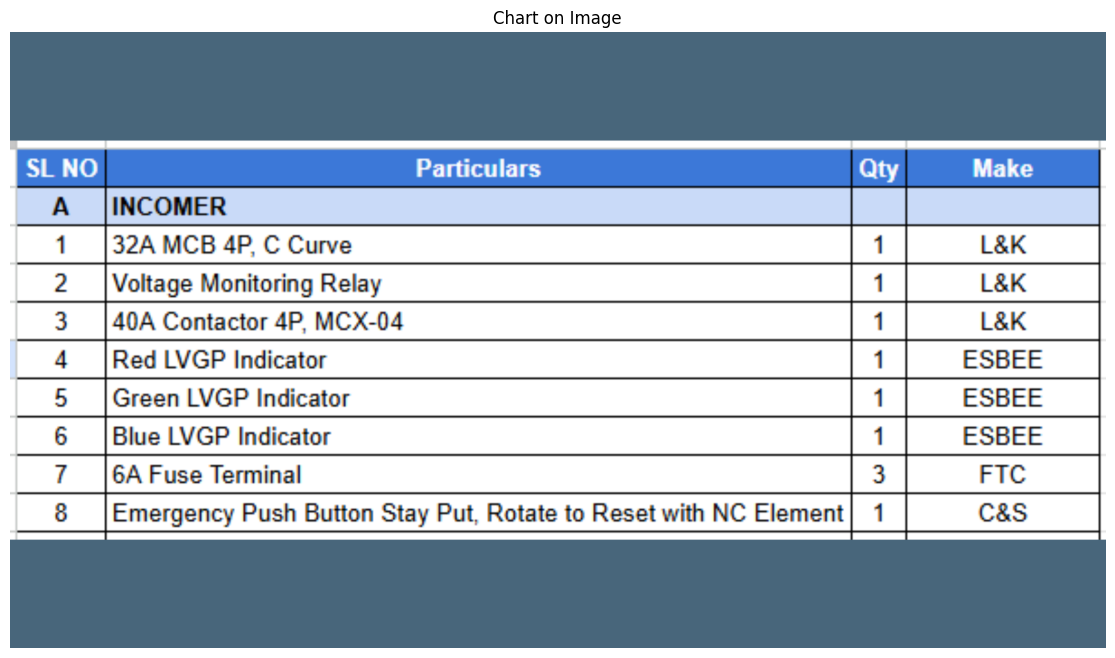

In [51]:
table_img = Image.open('../../tasks/table.png')
plt.figure(figsize=(16,8))
plt.imshow(table_img); plt.title("Chart on Image");
plt.axis("off")

In [47]:
torch.cuda.reset_peak_memory_stats()
t1 = time.time()
# Without reasoning for simple questions
result = moondream.query(
    image=table_img, 
    question="Can you output the table in the image in markdown format?",
    reasoning=False
)
t2 = time.time()
peak = torch.cuda.max_memory_allocated() / (1024**3)
print(f"Peak memory: {peak:.2f} GB")
print(f"Time taken : {round(t2-t1,2)} s")

print(result["answer"])

Peak memory: 18.40 GB
Time taken : 62.12 s
| SL NO | Particulars | Qty | Make |
| ------ | ---------- | ---- | --- |
| A | INCOMER | 1 | L&K |
| 1 | 32A MCB 4P, C Curve | 1 | L&K |
| 2 | Voltage Monitoring Relay | 1 | L&K |
| 3 | 40A Contactor 4P, MCX-04 | 1 | L&K |
| 4 | Red LVGP Indicator | 1 | ESBEE |
| 5 | Green LVGP Indicator | 1 | ESBEE |
| 6 | Blue LVGP Indicator | 1 | ESBEE |
| 7 | 6A Fuse Terminal | 3 | FTC |
| 8 | Emergency Push Button Stay Put, Rotate to Reset with NC Element | 1 | C&S |
